<a href="https://www.kaggle.com/code/surajthakur21/podcast-prediction-xgboost-optuna?scriptVersionId=231992146" target="_blank"><img align="left" alt="Kaggle" title="Open in Kaggle" src="https://kaggle.com/static/images/open-in-kaggle.svg"></a>

In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/playground-series-s5e4/sample_submission.csv
/kaggle/input/playground-series-s5e4/train.csv
/kaggle/input/playground-series-s5e4/test.csv


In [2]:
train = pd.read_csv("/kaggle/input/playground-series-s5e4/train.csv")

In [3]:
test = pd.read_csv("/kaggle/input/playground-series-s5e4/test.csv")

In [4]:
sample_submission = pd.read_csv("/kaggle/input/playground-series-s5e4/sample_submission.csv")

In [5]:
train.head()

/usr/local/lib/python3.10/dist-packages/pandas/io/formats/format.py:1458: RuntimeWarning: invalid value encountered in greater
  has_large_values = (abs_vals > 1e6).any()
/usr/local/lib/python3.10/dist-packages/pandas/io/formats/format.py:1459: RuntimeWarning: invalid value encountered in less
  has_small_values = ((abs_vals < 10 ** (-self.digits)) & (abs_vals > 0)).any()
/usr/local/lib/python3.10/dist-packages/pandas/io/formats/format.py:1459: RuntimeWarning: invalid value encountered in greater
  has_small_values = ((abs_vals < 10 ** (-self.digits)) & (abs_vals > 0)).any()


,id,Podcast_Name,Episode_Title,Episode_Length_minutes,Genre,Host_Popularity_percentage,Publication_Day,Publication_Time,Guest_Popularity_percentage,Number_of_Ads,Episode_Sentiment,Listening_Time_minutes
0,0,Mystery Matters,Episode 98,NaN,True Crime,74.81,Thursday,Night,NaN,0.0,Positive,31.41998
1,1,Joke Junction,Episode 26,119.80,Comedy,66.95,Saturday,Afternoon,75.95,2.0,Negative,88.01241
2,2,Study Sessions,Episode 16,73.90,Education,69.97,Tuesday,Evening,8.97,0.0,Negative,44.92531
3,3,Digital Digest,Episode 45,67.17,Technology,57.22,Monday,Morning,78.70,2.0,Positive,46.27824
4,4,Mind & Body,Episode 86,110.51,Health,80.07,Monday,Afternoon,58.68,3.0,Neutral,75.61031


In [6]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 750000 entries, 0 to 749999
Data columns (total 12 columns):
 #   Column                       Non-Null Count   Dtype  
---  ------                       --------------   -----  
 0   id                           750000 non-null  int64  
 1   Podcast_Name                 750000 non-null  object 
 2   Episode_Title                750000 non-null  object 
 3   Episode_Length_minutes       662907 non-null  float64
 4   Genre                        750000 non-null  object 
 5   Host_Popularity_percentage   750000 non-null  float64
 6   Publication_Day              750000 non-null  object 
 7   Publication_Time             750000 non-null  object 
 8   Guest_Popularity_percentage  603970 non-null  float64
 9   Number_of_Ads                749999 non-null  float64
 10  Episode_Sentiment            750000 non-null  object 
 11  Listening_Time_minutes       750000 non-null  float64
dtypes: float64(5), int64(1), object(6)
memory usage: 68.7+ MB


In [7]:
train.describe()

,id,Episode_Length_minutes,Host_Popularity_percentage,Guest_Popularity_percentage,Number_of_Ads,Listening_Time_minutes
count,750000.000000,662907.000000,750000.000000,603970.000000,749999.000000,750000.000000
mean,374999.500000,64.504738,59.859901,52.236449,1.348855,45.437406
std,216506.495284,32.969603,22.873098,28.451241,1.151130,27.138306
min,0.000000,0.000000,1.300000,0.000000,0.000000,0.000000
25%,187499.750000,35.730000,39.410000,28.380000,0.000000,23.178350
50%,374999.500000,63.840000,60.050000,53.580000,1.000000,43.379460
75%,562499.250000,94.070000,79.530000,76.600000,2.000000,64.811580
max,749999.000000,325.240000,119.460000,119.910000,103.910000,119.970000


# Data Visualization

In [8]:
import matplotlib.pyplot as plt
import seaborn as sns

In [9]:
sns.set_style('darkgrid')
sns.set_palette('husl')

In [10]:
numerical_features = train.select_dtypes(['int64','float64']).columns
numerical_features

Index(['id', 'Episode_Length_minutes', 'Host_Popularity_percentage',
       'Guest_Popularity_percentage', 'Number_of_Ads',
       'Listening_Time_minutes'],
      dtype='object')

In [11]:
categorical_features = train.select_dtypes(['object']).columns
categorical_features

Index(['Podcast_Name', 'Episode_Title', 'Genre', 'Publication_Day',
       'Publication_Time', 'Episode_Sentiment'],
      dtype='object')

/usr/local/lib/python3.10/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/usr/local/lib/python3.10/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/usr/local/lib/python3.10/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/usr/local/lib/python3.10/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  

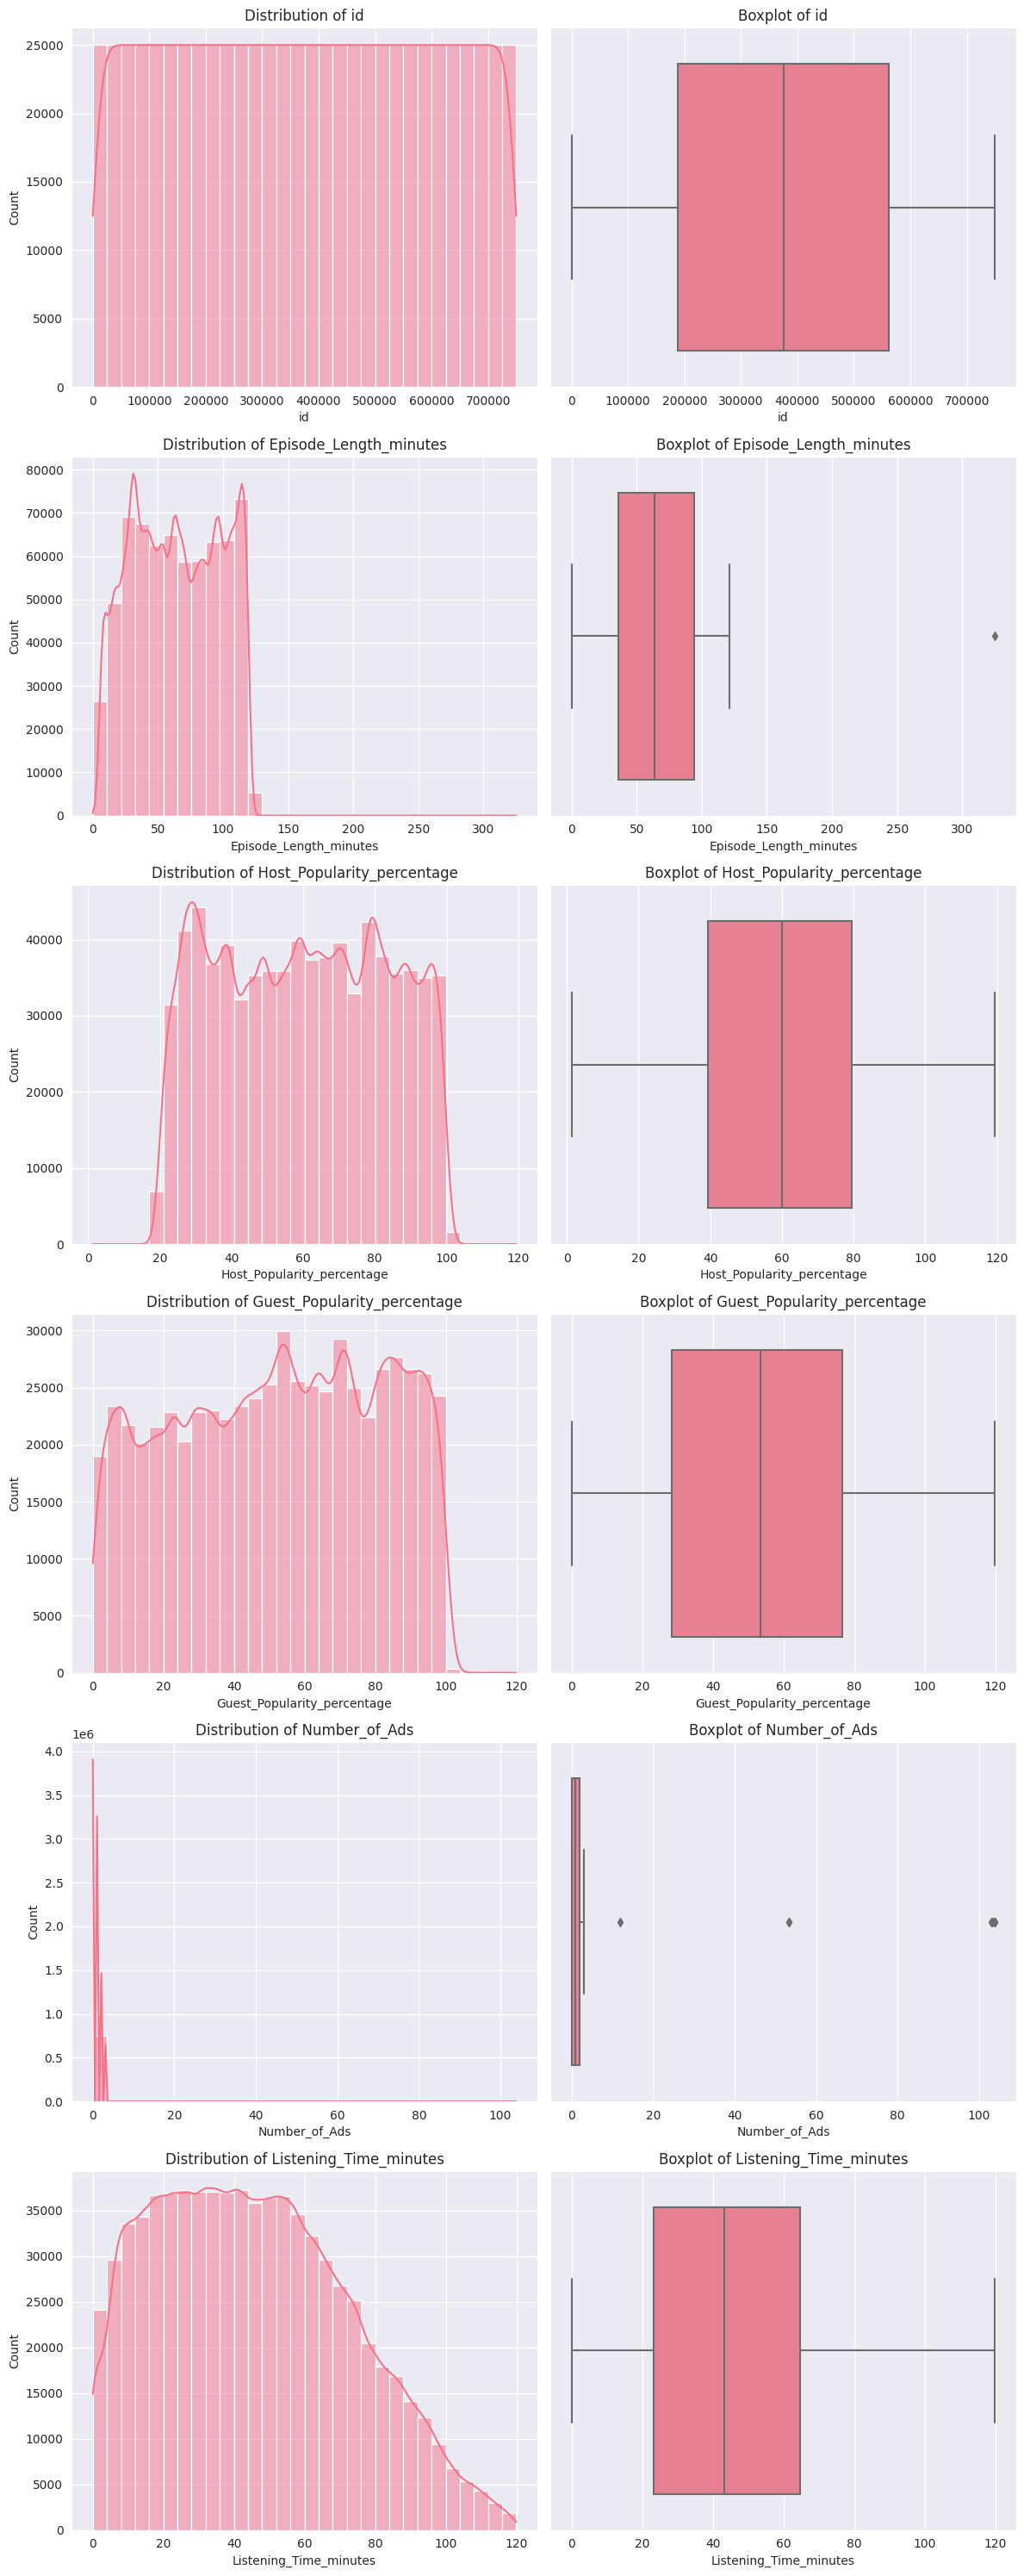

In [12]:
# Set up subplots
fig, axes = plt.subplots(len(numerical_features), 2, figsize=(12, 5 * len(numerical_features)))

for i, col in enumerate(numerical_features):
    # Histogram
    sns.histplot(train[col], bins=30, kde=True, ax=axes[i, 0])
    axes[i, 0].set_title(f"Distribution of {col}")

    # Boxplot
    sns.boxplot(x=train[col], ax=axes[i, 1])
    axes[i, 1].set_title(f"Boxplot of {col}")

plt.tight_layout()
plt.show()

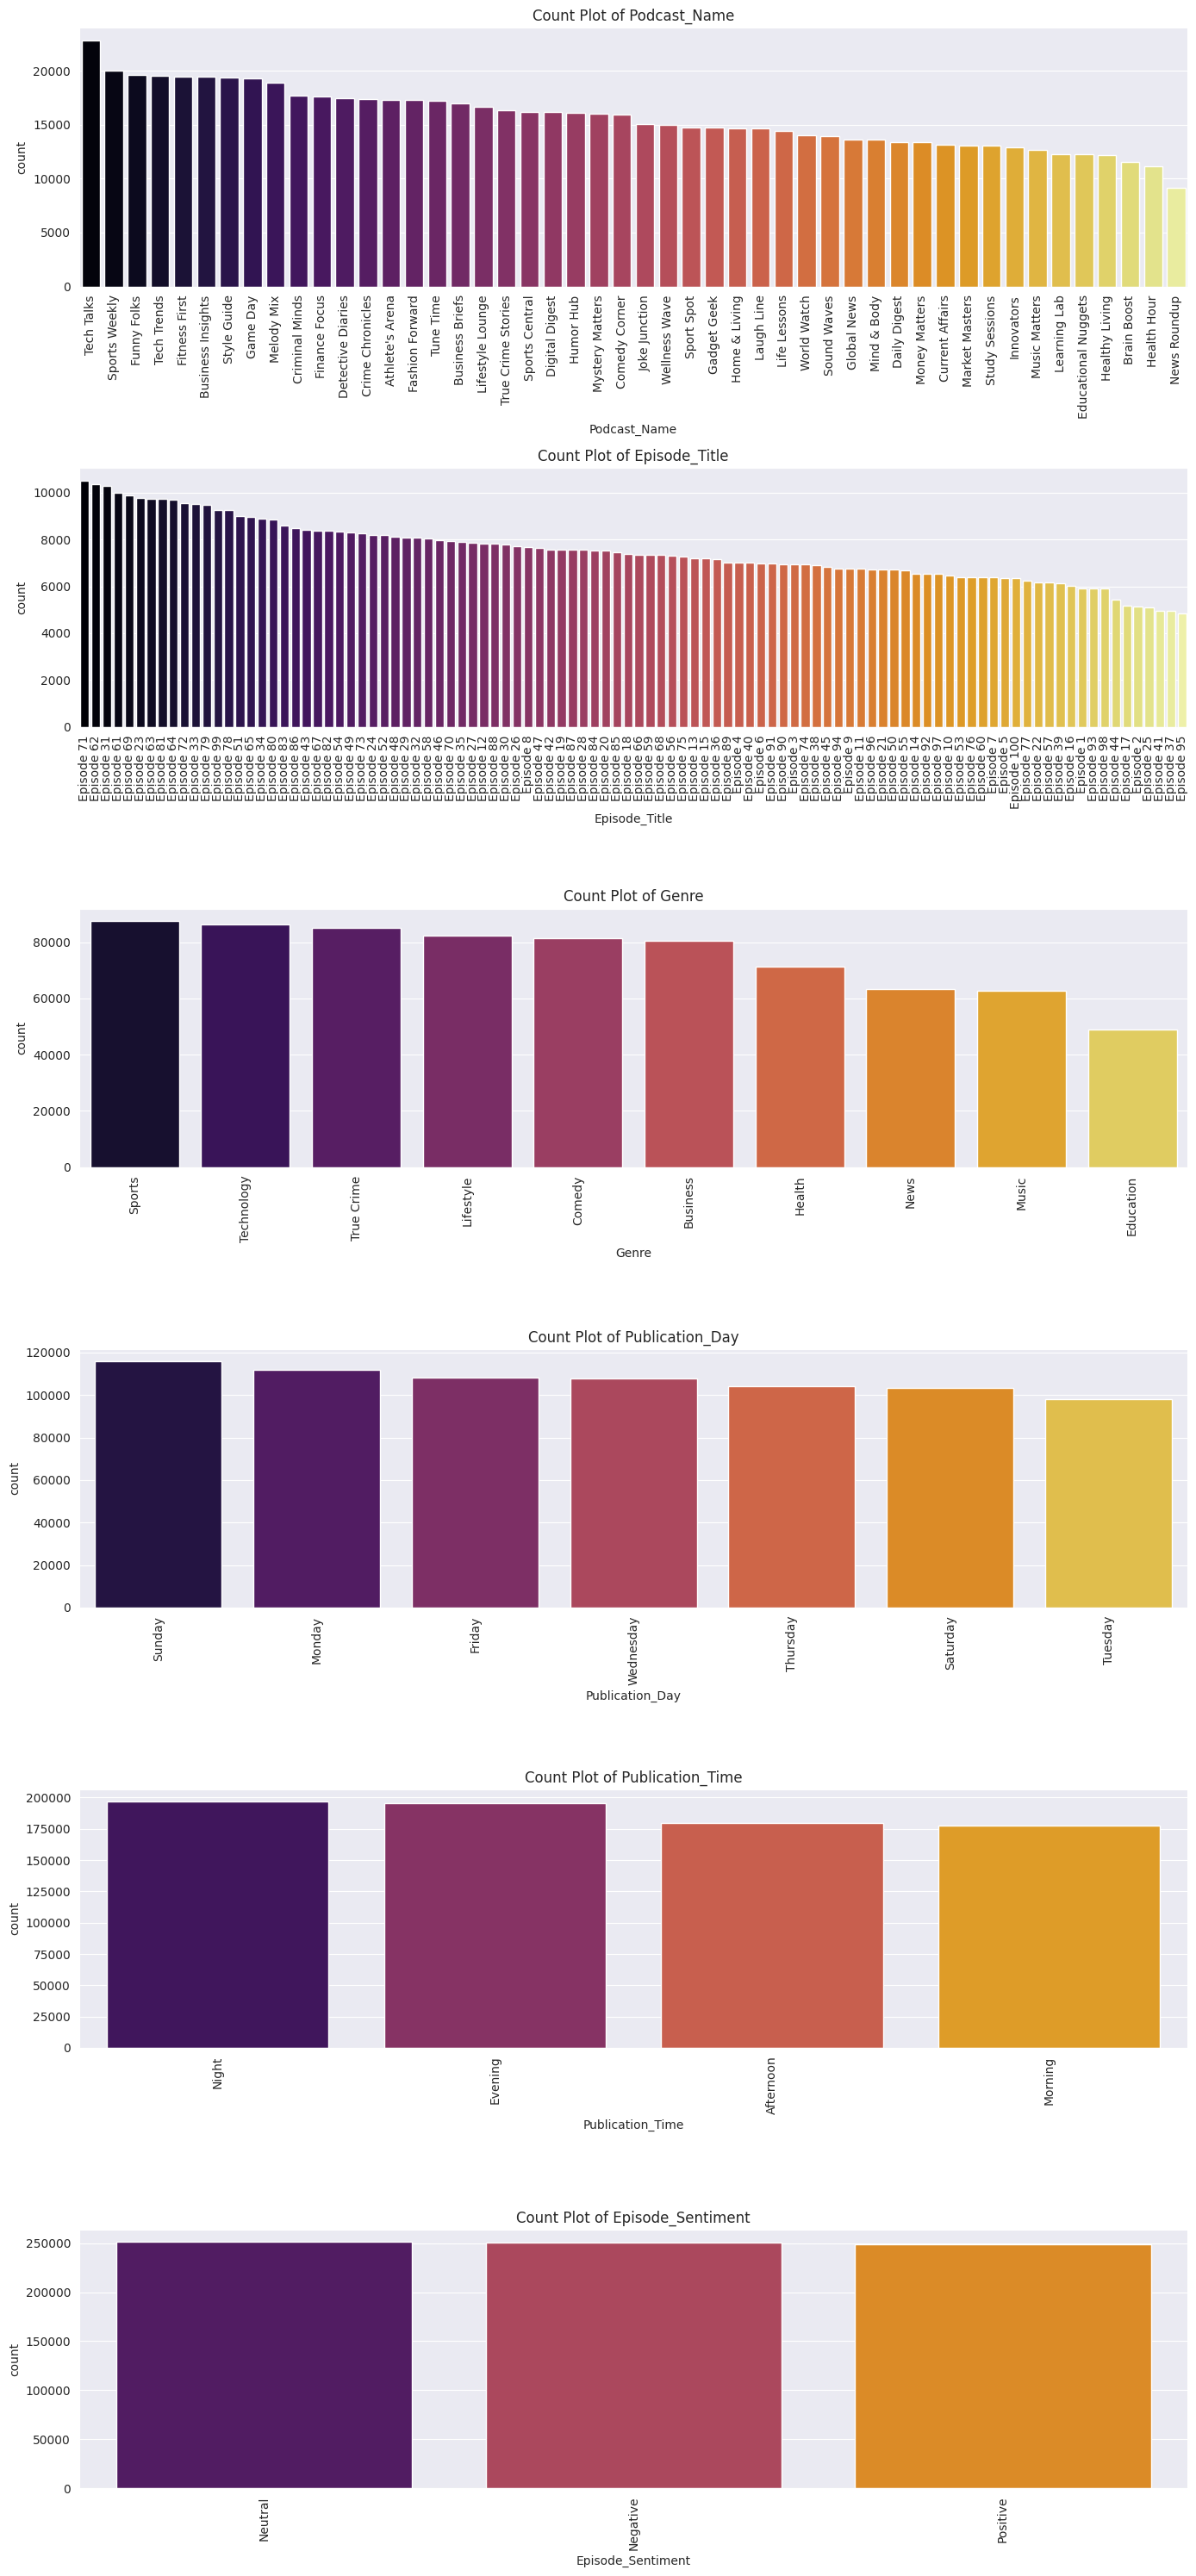

In [13]:
# Set up subplots
fig, axes = plt.subplots(len(categorical_features), 1, figsize=(14, 5 * len(categorical_features)))

for i, col in enumerate(categorical_features):
    sns.countplot(x=train[col], order=train[col].value_counts().index, ax=axes[i], palette="inferno")
    axes[i].set_title(f"Count Plot of {col}")
    axes[i].set_xticklabels(axes[i].get_xticklabels(), rotation=90)  # Rotate for readability

plt.tight_layout()
plt.show()


Text(0.5, 1.0, 'Corelation Heatmap: ')

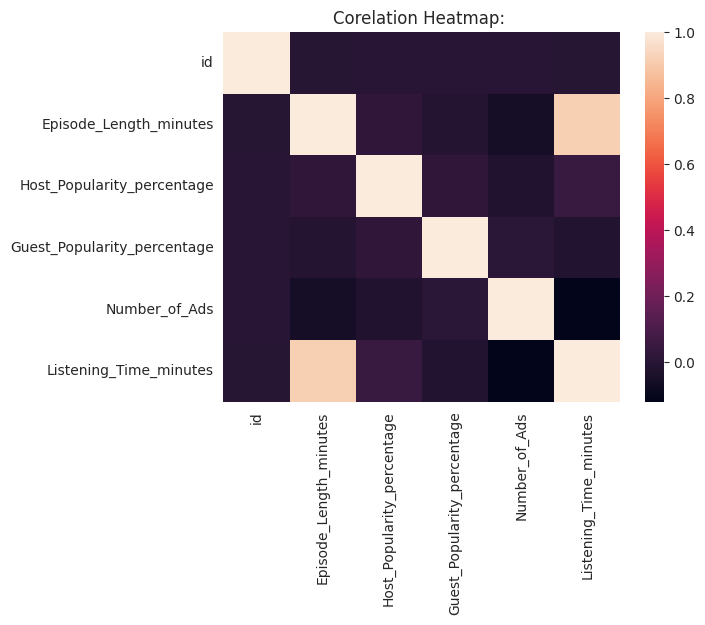

In [14]:
sns.heatmap(train[numerical_features].corr())
plt.title("Corelation Heatmap: ")

# Data Preprocessing

## 1. Handling Missing Values

In [15]:
train.isnull().sum()

id                                  0
Podcast_Name                        0
Episode_Title                       0
Episode_Length_minutes          87093
Genre                               0
Host_Popularity_percentage          0
Publication_Day                     0
Publication_Time                    0
Guest_Popularity_percentage    146030
Number_of_Ads                       1
Episode_Sentiment                   0
Listening_Time_minutes              0
dtype: int64

In [16]:
# Percentage of missing values in training data

train.isnull().sum()/train.count()*100

id                              0.000000
Podcast_Name                    0.000000
Episode_Title                   0.000000
Episode_Length_minutes         13.138042
Genre                           0.000000
Host_Popularity_percentage      0.000000
Publication_Day                 0.000000
Publication_Time                0.000000
Guest_Popularity_percentage    24.178353
Number_of_Ads                   0.000133
Episode_Sentiment               0.000000
Listening_Time_minutes          0.000000
dtype: float64

In [17]:
test.isnull().sum()

id                                 0
Podcast_Name                       0
Episode_Title                      0
Episode_Length_minutes         28736
Genre                              0
Host_Popularity_percentage         0
Publication_Day                    0
Publication_Time                   0
Guest_Popularity_percentage    48832
Number_of_Ads                      0
Episode_Sentiment                  0
dtype: int64

In [18]:
# Percentage of missing values in test data

test.isnull().sum()/test.count()*100

id                              0.000000
Podcast_Name                    0.000000
Episode_Title                   0.000000
Episode_Length_minutes         12.987201
Genre                           0.000000
Host_Popularity_percentage      0.000000
Publication_Day                 0.000000
Publication_Time                0.000000
Guest_Popularity_percentage    24.274238
Number_of_Ads                   0.000000
Episode_Sentiment               0.000000
dtype: float64

In [19]:
train

/usr/local/lib/python3.10/dist-packages/pandas/io/formats/format.py:1458: RuntimeWarning: invalid value encountered in greater
  has_large_values = (abs_vals > 1e6).any()
/usr/local/lib/python3.10/dist-packages/pandas/io/formats/format.py:1459: RuntimeWarning: invalid value encountered in less
  has_small_values = ((abs_vals < 10 ** (-self.digits)) & (abs_vals > 0)).any()
/usr/local/lib/python3.10/dist-packages/pandas/io/formats/format.py:1459: RuntimeWarning: invalid value encountered in greater
  has_small_values = ((abs_vals < 10 ** (-self.digits)) & (abs_vals > 0)).any()


,id,Podcast_Name,Episode_Title,Episode_Length_minutes,Genre,Host_Popularity_percentage,Publication_Day,Publication_Time,Guest_Popularity_percentage,Number_of_Ads,Episode_Sentiment,Listening_Time_minutes
0,0,Mystery Matters,Episode 98,NaN,True Crime,74.81,Thursday,Night,NaN,0.0,Positive,31.41998
1,1,Joke Junction,Episode 26,119.80,Comedy,66.95,Saturday,Afternoon,75.95,2.0,Negative,88.01241
2,2,Study Sessions,Episode 16,73.90,Education,69.97,Tuesday,Evening,8.97,0.0,Negative,44.92531
3,3,Digital Digest,Episode 45,67.17,Technology,57.22,Monday,Morning,78.70,2.0,Positive,46.27824
4,4,Mind & Body,Episode 86,110.51,Health,80.07,Monday,Afternoon,58.68,3.0,Neutral,75.61031
...,...,...,...,...,...,...,...,...,...,...,...,...
749995,749995,Learning Lab,Episode 25,75.66,Education,69.36,Saturday,Morning,NaN,0.0,Negative,56.87058
749996,749996,Business Briefs,Episode 21,75.75,Business,35.21,Saturday,Night,NaN,2.0,Neutral,45.46242
749997,749997,Lifestyle Lounge,Episode 51,30.98,Lifestyle,78.58,Thursday,Morning,84.89,0.0,Negative,15.26000
749998,749998,Style Guide,Episode 47,108.98,Lifestyle,45.39,Thursday,Morning,93.27,0.0,Negative,100.72939


In [20]:
columns_to_fill_with_mean = ['Guest_Popularity_percentage', 'Episode_Length_minutes']
columns_to_fill_with_mode = ['Number_of_Ads']

for col in columns_to_fill_with_mean:
    train[col] = train[col].fillna(train[col].mean())

for col in columns_to_fill_with_mode:
    train[col] = train[col].fillna(train[col].mode()[0])

for col in columns_to_fill_with_mean:
    test[col] = test[col].fillna(test[col].mean())

for col in columns_to_fill_with_mode:
    test[col] = test[col].fillna(test[col].mode()[0])

In [21]:
train

,id,Podcast_Name,Episode_Title,Episode_Length_minutes,Genre,Host_Popularity_percentage,Publication_Day,Publication_Time,Guest_Popularity_percentage,Number_of_Ads,Episode_Sentiment,Listening_Time_minutes
0,0,Mystery Matters,Episode 98,64.504738,True Crime,74.81,Thursday,Night,52.236449,0.0,Positive,31.41998
1,1,Joke Junction,Episode 26,119.800000,Comedy,66.95,Saturday,Afternoon,75.950000,2.0,Negative,88.01241
2,2,Study Sessions,Episode 16,73.900000,Education,69.97,Tuesday,Evening,8.970000,0.0,Negative,44.92531
3,3,Digital Digest,Episode 45,67.170000,Technology,57.22,Monday,Morning,78.700000,2.0,Positive,46.27824
4,4,Mind & Body,Episode 86,110.510000,Health,80.07,Monday,Afternoon,58.680000,3.0,Neutral,75.61031
...,...,...,...,...,...,...,...,...,...,...,...,...
749995,749995,Learning Lab,Episode 25,75.660000,Education,69.36,Saturday,Morning,52.236449,0.0,Negative,56.87058
749996,749996,Business Briefs,Episode 21,75.750000,Business,35.21,Saturday,Night,52.236449,2.0,Neutral,45.46242
749997,749997,Lifestyle Lounge,Episode 51,30.980000,Lifestyle,78.58,Thursday,Morning,84.890000,0.0,Negative,15.26000
749998,749998,Style Guide,Episode 47,108.980000,Lifestyle,45.39,Thursday,Morning,93.270000,0.0,Negative,100.72939


In [22]:
train['Episode_Title'].str.split(" ").str[-1].unique()

array(['98', '26', '16', '45', '86', '19', '47', '44', '32', '81', '66',
       '62', '76', '37', '20', '82', '72', '61', '100', '54', '17', '36',
       '97', '27', '31', '88', '38', '92', '74', '30', '63', '67', '77',
       '4', '93', '24', '1', '2', '25', '56', '75', '12', '21', '6', '85',
       '23', '33', '7', '53', '15', '43', '71', '69', '13', '89', '3',
       '64', '73', '79', '94', '80', '42', '10', '48', '96', '40', '49',
       '9', '50', '78', '84', '87', '58', '57', '59', '39', '46', '91',
       '35', '8', '90', '5', '65', '11', '51', '99', '14', '41', '18',
       '95', '83', '55', '29', '68', '34', '22', '60', '52', '28', '70'],
      dtype=object)

In [23]:
train['Episode_Title'] = train['Episode_Title'].str.split(" ").str[-1]
test['Episode_Title'] = test['Episode_Title'].str.split(" ").str[-1]

## 2. Encoding Categorical Features

In [24]:
train[categorical_features].nunique()

Podcast_Name          48
Episode_Title        100
Genre                 10
Publication_Day        7
Publication_Time       4
Episode_Sentiment      3
dtype: int64

1. Genre --> One Hot Encoding 
2. Publication_Day --> One Hot Encoding
3. Publication_Time --> One Hot Encoding
4. Episode_Sentiment --> Ordinal Encoding


In [25]:
# Encoding using pd.get_dummies()

# train_encoded_columns = pd.get_dummies(train[['Genre','Publication_Day','Publication_Time']],dtype=int)
# test_encoded_columns = pd.get_dummies(test[['Genre','Publication_Day','Publication_Time']],dtype=int)

# train = pd.concat([train, train_encoded_columns], axis=1)
# test = pd.concat([test, test_encoded_columns], axis=1)

In [26]:
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder, OrdinalEncoder, StandardScaler, MinMaxScaler

In [27]:
# Define ordinal categories 
Episode_Sentiment = [['Negative', 'Neutral', 'Positive']]

In [28]:
one_hot_cols = ['Genre','Publication_Day','Publication_Time']
ordinal_cols = ['Episode_Sentiment']

In [29]:
numerical_features

Index(['id', 'Episode_Length_minutes', 'Host_Popularity_percentage',
       'Guest_Popularity_percentage', 'Number_of_Ads',
       'Listening_Time_minutes'],
      dtype='object')

In [30]:
num_cols = ['id', 'Episode_Length_minutes', 'Host_Popularity_percentage','Guest_Popularity_percentage', 'Number_of_Ads']

In [31]:
X = train.drop(columns=['Listening_Time_minutes'])
y = train['Listening_Time_minutes']


In [32]:
preprocessor = ColumnTransformer([
    ('one_hot', OneHotEncoder(handle_unknown='ignore'), one_hot_cols),
    ('ordinal', OrdinalEncoder(categories=Episode_Sentiment), ordinal_cols),
    ('scaler', StandardScaler(), num_cols)
])

In [33]:
train_transformed = preprocessor.fit_transform(train)
test_transformed = preprocessor.transform(test)

In [34]:
from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBRegressor
from sklearn.metrics import mean_squared_error

In [35]:
y_test = sample_submission['Listening_Time_minutes']

# Model Defination (XGBoost)

In [36]:
import optuna

In [37]:
# Define the objective function for Optuna
def objective(trial):
    params = {
        "n_estimators": trial.suggest_int("n_estimators", 20, 50),
        "max_depth": trial.suggest_int("max_depth", 3, 7),
        "learning_rate": trial.suggest_float("learning_rate", 0.05, 0.1),
        "subsample": trial.suggest_float("subsample", 0.6, 0.9),
        "colsample_bytree": trial.suggest_float("colsample_bytree", 0.5, 1.0),
        "min_child_weight": trial.suggest_int("min_child_weight", 3, 10),
        "reg_alpha": trial.suggest_float("reg_alpha", 0.0, 1.0),
        "reg_lambda": trial.suggest_float("reg_lambda", 0.0, 1.0),
        'eval_metric': 'rmse',
    }

    # Train XGBoost model with these parameters
    model = XGBRegressor(**params, random_state=42)
    model.fit(train_transformed, y)

    # Predict on validation set and compute RMSE
    preds = model.predict(test_transformed)
    rmse = np.sqrt(mean_squared_error(y_test, preds))
    
    return rmse  # Optuna minimizes RMSE

In [38]:
# Run Optuna study for hyperparameter tuning
study = optuna.create_study(direction="minimize")
study.optimize(objective, n_trials=15)

[I 2025-04-05 05:06:36,751] A new study created in memory with name: no-name-23da9a87-e71a-436b-9140-2b4c67f9767d
[I 2025-04-05 05:06:39,547] Trial 0 finished with value: 22.335886123298454 and parameters: {'n_estimators': 36, 'max_depth': 6, 'learning_rate': 0.061627450566368085, 'subsample': 0.6602962282948206, 'colsample_bytree': 0.5046874882006152, 'min_child_weight': 4, 'reg_alpha': 0.23843815809076352, 'reg_lambda': 0.6647082031415094}. Best is trial 0 with value: 22.335886123298454.
[I 2025-04-05 05:06:42,384] Trial 1 finished with value: 23.301224876585707 and parameters: {'n_estimators': 38, 'max_depth': 6, 'learning_rate': 0.05287005086722318, 'subsample': 0.6983666058920281, 'colsample_bytree': 0.8501904885212668, 'min_child_weight': 10, 'reg_alpha': 0.866804894571457, 'reg_lambda': 0.4476273883491174}. Best is trial 0 with value: 22.335886123298454.
[I 2025-04-05 05:06:45,131] Trial 2 finished with value: 22.82087121401675 and parameters: {'n_estimators': 32, 'max_depth': 7

In [39]:
# Best parameters from Optuna
best_params = study.best_params
print(f"Best Hyperparameters: {best_params}")

Best Hyperparameters: {'n_estimators': 22, 'max_depth': 6, 'learning_rate': 0.05793677989139266, 'subsample': 0.6039593580655092, 'colsample_bytree': 0.5017757230275971, 'min_child_weight': 7, 'reg_alpha': 0.060312867307104945, 'reg_lambda': 0.6476835313901046}


In [40]:
# Train XGBoost with best parameters
best_xgb = XGBRegressor(**best_params, random_state=42)
best_xgb.fit(train_transformed, y)

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=0.5017757230275971, device=None,
             early_stopping_rounds=None, enable_categorical=False,
             eval_metric=None, feature_types=None, gamma=None, grow_policy=None,
             importance_type=None, interaction_constraints=None,
             learning_rate=0.05793677989139266, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=6, max_leaves=None,
             min_child_weight=7, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=22, n_jobs=None,
             num_parallel_tree=None, random_state=42, ...)

In [41]:
# Final evaluation on test set
xgb_preds = best_xgb.predict(test_transformed)
final_rmse = np.sqrt(mean_squared_error(y_test, xgb_preds))
print(f"Final XGBoost RMSE: {final_rmse:.4f}")

Final XGBoost RMSE: 15.9188


In [42]:
sample_submission.shape,xgb_preds.shape

((250000, 2), (250000,))

# Saving Submission file

In [43]:
submission = pd.DataFrame({
    'id': sample_submission['id'],
    'Listening_Time_minutes': xgb_preds
})

In [44]:
submission.to_csv('submission.csv', index=False)
print("Submission file saved as submission.csv")

Submission file saved as submission.csv
